---
<a id='top'></a>

# Create Figures

This notebook will explain how to create figures using the code provided in this repository. If you have any questions about the contents of this notebook or are having difficulties running the code, please contact us using the information in the README file.


## Table of Contents

* [Before you start](#before_you_start)
* [Figure 1](#figure_1)
* [Figure 2](#figure_2)
* [Figure 3](#figure_3)
* [Figure 4](#figure_4)
* [Figure 5](#figure_5)
* [Figure 6](#figure_6)
* [Figure 7](#figure_7)
* [Figure 8](#figure_8)
* [Other Figures](#other_figures)
    * [Histograms](#histo_grams)
    * [Adjusting HDBSCAN parameters](#HDBSCAN_params)
    * [Re-gridding temperature and slainity data](#re_gridding)

---
<a id='before_you_start'></a>
[back to top](#top)

## Before you start

NOTE: To create the figures below and the figures from the paper, you will need to first download the ITP data files for [ITP2](https://www2.whoi.edu/site/itp/data/completed-missions/itp-2/itp-2-final-data/) and [ITP3](https://www2.whoi.edu/site/itp/data/completed-missions/itp-3/itp-3-final-data/) from the Woods Hole Oceanographic Institution (WHOI). "The Ice-Tethered Profiler data were collected and made available by the Ice-Tethered Profiler Program (Toole et al., 2011; Krishfield et al., 2008) based at the Woods Hole Oceanographic Institution (https://www2.whoi.edu/site/itp/)." Download the "Level III 1-Hz processed profile data in MATLAB format" which have filenames like `itpXcormat.tar.Z` or `itpXcormat.zip`. Unzip the files and arrange them into the following directory structure:
```
`ITPs/`
    |
    -> `itp2/`
            |
            -> `itp2cormat/`
                            |
                            -> `cor0001.mat`
                            -> `cor0002.mat`
                                ...
                            -> `cor0244.mat`
    -> `itp3/`
            |
            -> `itp3cormat/`
                            |
                            -> `cor0001.mat`
                            -> `cor0002.mat`
                                ...
                            -> `cor1532.mat`
```

In the `make_netcdf.py` script, change the variable `science_data_file_path` to be the string for the absolute path to the directory which contains your `ITPs` folder. This will tell the script where to look for the original data files. Then run the following scripts in this order:
* `make_netcdf.py`
* `take_moving_average.py`
* `cluster_data.py`

Depending on your computer, these might take a while to run, especially `cluster_data.py`, but for all of the plots in this notebook, you will only need to run them once. When completed, there will be two netcdf files `ITP_2.nc` and `ITP_3.nc` in the newly created `netcdfs/` sub-directory. All of the plotting functions here will use data that is stored in these netcdf files.

#### `make_netcdfs.py`

This script takes data files from ocean profilers and converts them into netcdf files, one for each instrument. Note that, for netcdf files, in order to add a new variable, you must completely re-create the file, there is no way to add a variable to an existing file. To see the variables that one of these netcdfs will contain, see the `nc_vars` dictionary inside the `read_instrmt()` function. 

This script is currently set up to read the Level III 1-Hz processed profile data in MATLAB format from ITP2 and ITP3, but you can add as many other ITPs as you would like, following the calls to `read_instrmt()` at the bottom of the script. The Level III 1-Hz processed profile data is the full ~25 cm resolution captured by ITPs. The `make_netcdfs.py` script can also read and make netcdf files from the Level III 1-db bin-averaged processed profile data in ASCII format, but the binning process reduces the vertical resolution, washing away some of the fine-scale structure of staircases, and therefore isn't recommended for use with the staircase clustering detection algorithm.

#### `take_moving_average.py`

This script takes netcdf files that have been created by `make_netcdfs.py` and adds values into the following moving average variables: `ma_iT`, `ma_CT`, `ma_PT`, `ma_SP`, `ma_SA`, and `ma_sigma`. The variable `c3` is the value of the rectangular moving average window ($\ell$) in dbar. It is currently set to 100 dbar, following the study. This script is separate from `make_netcdfs.py` to allow for the flexibility to change the value of $\ell$, which is relatively quick, without having to re-create the entire netcdf, which takes a bit of time.

This script will also automatically update some of the global parameters, which keep track of changes and settings for a netcdf. To see an example of the global attributes in a netcdf, run the following cell:

In [ ]:
# For custom analysis functions
import analysis_helper_functions as ahf
# Create a dataset from one of the netcdf files
ds_ITP2_all = ahf.Data_Set({'ITP_2':'all'}, ahf.Data_Filters())
# Print out the global attributes
g_attrs = ahf.print_global_variables(ds_ITP2_all)

#### `cluster_data.py`

This script takes netcdf files that were created by `make_netcdfs.py` and have been modified by `take_moving_average.py` and runs the HDBSCAN clustering algorithm, recording the results to the netcdf files. You do not need to run this script in order to cluster data. As will be covered later, the plotting scripts can run HDBSCAN at the time of plotting. However, running HDBSCAN over large amounts of data can take a long time. Therefore, if you run the `cluster_data.py` script with the input parameters you plan on using for many plots, you won't need to re-run the algorithm every time you plot as the script will be able to pull the clustering results from the netcdf files.

The `cluster_data.py` script is currently set up to cluster ITP2 and ITP3 with the same parameters as the study. These are specified in the clustering dictionaries in the file. For example:

In [ ]:
## Reproducing figures from Timmermans et al. 2008
ITP2_clstr_dict = {'netcdf_to_load':'netcdfs/ITP_2.nc',
                   'sources_dict':{'ITP_2':'all'},
                   'data_filters':ahf.Data_Filters(),
                   'SP_range':[34.05,34.75],
                   'cl_x_var':'SP',
                   'cl_y_var':'la_CT',
                   'm_pts':170
                   }

All of the elements of this dictionary will be explained in more detail in following sections, but for a quick explanation: The `netcdf_to_load` is the relative path to the netcdf to load, `sources_dict` is the dictionary of sources to include, `data_filters` is the `Data_Filters` object to use, `SP_range` is the range of practical salinity to filter to, `cl_x_var` and `cl_y_var` are the x and y variables to use to create the spatial arrangement to cluster on, and `m_pts` is the one input parameter required by HDBSCAN which sets a threshold on the minimum points per cluster.

---
<a id='preparing_to_plot'></a>
[back to top](#top)

## Preparing to plot

First, run this cell to import the packages needed for this notebook to run:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

The next step is to import the `analysis_helper_functions.py` script:

In [3]:
# For custom analysis functions
import analysis_helper_functions as ahf

The `analysis_helper_functions.py` script imports many standard and not-so-standard Python packages. It contains all of the functions and class definitions needed to create these figures. If you get errors from running the above import, make sure you install all the relevant packages listed in the import statements in that file. If you don't plan on making detailed maps, you can comment out the lines importing from `cartopy`. Under the section "Figure 1", I explain how to visualize geographical distributions without `cartopy`. 

Next, we create a set of custom plotting objects.

### Plotting objects

The plots that can be generated from this script are very customizable. It works 
by creating different instances of custom objects which can be combined to make
different types of plots. The objects that are created are, in order:
* `Data_Filters`
    * A set of rules to broadly filter the data
* `Data_Set`
    * Contains the data to be plotted
* `Profile_Filters`
    * A set of rules on how to filter individual profiles
* `Plot_Parameters`
    * A set of rules on how to plot the data
* `Analysis_Group`
    * Wraps the other objects, contains the information to make one subplot

The `Data_Filters`, `Data_Set`, `Profile_Filters`, and `Plot_Parameters` can be combined
in many different ways. For example, if you want to plot the same data in many 
different ways, you can make one `Data_Set` object and combine it with many different
`Plot_Parameters` objects. Or, if you want to compare many different data sets by 
make many of the same type of plot, you can make many `Data_Set` objects and combine
each with the same `Plot_Parameters` object.

#### Data Filters

A data filter object broadly filters the data based on 4 parameters:
* `keep_black_list`
    * Whether or not to include profiles that have been placed on the black list
        * Currently, none of the profiles for ITP2 or ITP3 are on this list
    * Default: `False`, to automatically disclude profiles on the black list
* `cast_direction`
    * Which directions of casts to include, either `up`, `down`, or `all`
    * Default: `up`, to disclude down-going profiles because of the wake problem
* `geo_extent`
    * Whether to filter to just profiles within a certain geographical region
        * `CS` for Chukchi Sea, `SBS` for Southern Beaufort Sea, `CB` for Canada Basin, `MB` for Markov Basin, `EB` for Eurasian Basin, `BS` for Barents Sea, or `None` for no geographical restrictions
    * Default: `None` to include all profiles available
* `date_range`
    * A list of two dates where only profiles that were taken between the two will be kept
        * `['start_date', 'end_date']` where the dates are strings in the format `YYYY/MM/DD` or `None` to keep all profiles
    * Default: `None` to include all profiles available

For the figures we will make below, we will create a `Data_Filters` object with all the default parameters, so no arguments are needed:

In [4]:
dfs0 = ahf.Data_Filters()

#### Data Sets

A `Data_Set` object contains the dictionary of sources to pull data from and an array of `xarray` data sets from those sources with the filters from a `Data_Filters` object applied upon creation of the `Data_Set` object. 

The dictionary passed to the `Data_Set` follows the format `{'source1_filename':'pfs_to_keep', 'source2_filename':'pfs_to_keep'}` where the source filenames are strings of the netcdf files you wish to include (without the `.nc`) and the `pfs_to_keep` are either lists of specific profile numbers or `all` to include all profiles from that source. 

Below are examples of source dictionaries for all profiles in multiple files, all profiles in just one file, and just some profiles in a file:

In [5]:
# All profiles from all ITPs in this study
all_ITPs = {'ITP_2':'all','ITP_3':'all'}

# All profiles from certain ITPs
ITP2_all  = {'ITP_2':'all'}
ITP3_all  = {'ITP_3':'all'}

# Some specific profiles
ITP2_pfs  = {'ITP_2':[183, 185, 187]}

Note: If you are hoping to make a plot of specific profiles but wish to rerun the clustering algorithm on a larger dataset, you should include all the profiles in your source dictionary. There are options to specify specific profiles to actually plot in the Plot Parameters objects, but the clustering algorithm will be run on the data you include here.

Now, we can use those dictionaries to create data set objects:

In [6]:
ds_all_ITPs = ahf.Data_Set(all_ITPs, dfs0)

ds_ITP2_all = ahf.Data_Set(ITP2_all, dfs0)
ds_ITP3_all = ahf.Data_Set(ITP3_all, dfs0)

ds_ITP2_pfs = ahf.Data_Set(ITP2_pfs, dfs0)

#### Profile Filters

A `Profile_Filters` object will filter what data you will include but, unlike a data filters object, it can filter out specific points within specific profiles. The filter options are as follows:
* Filtering on the vertical
    * `p_range`: a range of pressures (dbar), `[p_min, p_max]`
    * `d_range`: a range of depths (m), `[d_min, d_max]`
* Filtering on temperature
    * `iT_range`: a range of insitu temperatures ($^\circ$C), `[iT_min, iT_max]`
    * `CT_range`: a range of conservative temperatures ($^\circ$C), `[CT_min, CT_max]`
* Filtering on salinity
    * `SP_range`: a range of practical salinities (g/kg), `[SP_min, SP_max]`
    * `SA_range`: a range of absolute salinities (g/kg), `[SA_min, SA_max]`
* Subsample each profile, `subsample`
    * Either `True` or `False` as to whether to apply the subsample mask which can be added to a netcdf by running the `subsample_netcdf.py` script
* Regrid temperature and salinity, `regrid_TS`
    * Either `True` or `False` as to whether to regrid temperature and salinity onto a particular lower-resolution grid
* Re-run moving average, `m_avg_win`
    * A value in dbar for $\ell$ to use when running `take_m_avg()` before plotting
    * While `take_m_avg()` and `take_moving_average` do the same thing, the results of `take_m_avg()` are not recorded to any netcdf files

To recreate the plots in the study, we will only be filtering to ranges in practical salinity, so here we create those needed `Profile_Filter` objects:

In [7]:
# Define practical salinity ranges to use
ITP2_SP_range = [34.05, 34.75]
ITP3_SP_range = [34.21, 34.82]
# Create Profile_Filters objects
pfs_ITP2 = ahf.Profile_Filters(SP_range=ITP2_SP_range)
pfs_ITP3 = ahf.Profile_Filters(SP_range=ITP3_SP_range)
# Create a Profile_Filters object with the default filters
pfs_0 = ahf.Profile_Filters()

#### Plot Parameters

A `Plot_Parameters` object contains the necessary information to format one subplot. There are many parameters which can be contained in a `Plot_Parameters` object. Below are some of the most important, while other parameters that are very situation-specific will be explained as they appear in following sections.
* `plot_type`
    * What kind of plot to make, either `xy` (just two variables plotted against each other), `map`, or `profiles`
    * Defaults to `xy`
* `x_vars`
    * A list of up to two strings specifying the variables which will be on the x-axis (horizontal)
* `y_vars`
    * A list of up to two strings specifying the variables which will be on the y-axis (vertical)
* `legend`
    * Either `True` or `False` as to whether to include a legend on this subplot
* `ax_lims`
    * A dictionary containing the axis limits for the final plot
    * Ex: `{'x_lims':[x_min,x_max], 'y_lims':[y_min,y_max]}`
    * Note: only works for axes that have one variable
* `clr_map`
    * A string specifying the colormap to use for the data
    * Options include: 
        * `clr_all_same` colors every point a standard color
            * This is the default option 
        * `clr_by_source` colors data from each source a different color
        * `clr_by_instrmt` colors data from each instrument a different color
        * `density_hist` makes a 2D histogram with the color-scale representing the density of points in the chosen variable space
        * `cluster` colors each point by the cluster it was put in, or as noise
        * Any regular variable string, which will color the points on the scale of the chosen variable
* `extra_args`
    * A catch-all dictionary for parameters that are only used in specific circumstances

The following is an example `Plot_Parameters` object which will plot practical salinity versus conservative temperature with a color map of pressure:

In [ ]:
pp_test0 = ahf.Plot_Parameters(x_vars=['SP'], y_vars=['CT'], legend=True, clr_map='press')

#### Analysis Groups

As the analysis groups contain the data to plot and the rules by which to plot the data, each analysis group represents a subplot. They accept the following arguments:
* `data_set`
    * A `Data_Set` object, as described above
* `profile_filters`
    * A `Profile_Filters` object, as described above
* `plt_params`
    * A `Plot_Parameters` object, as described above
* `plot_title`
    * An optional argument, a string of what the subplot's title will be
    * If none is given, the plot will have a standard title which depends on the type of plot

Here, we create two analysis groups, one for ITP2 and ITP3, but both using the same profile filters and plot parameters:

In [ ]:
group_ITP2_test0 = ahf.Analysis_Group(ds_ITP2_all, pfs_0, pp_test0)
group_ITP3_test0 = ahf.Analysis_Group(ds_ITP3_all, pfs_0, pp_test0)

### Making a figure

Between 1 and 9 analysis groups can be combined using the `make_figure()` function to produce a plot, either
as an image in the GUI, an image file, or a pickle file. The arguments it accepts are as follows:
* `groups_to_plot`
    * A list of `Analysis_Group` objects to plot
    * Note, you still must give a list even if it only has one `Analysis_Group`
    * The order of this list determines the order of the subplots
* `filename`
    * If given a file name that ends in `.png` or `.pickle`, the plot will be saved to that file
    * If no file name is given, the plot will appear in the matplotlib GUI
* `use_same_x_axis` and `use_same_y_axis`
    * Used to override automatically sharing x or y axes when neighboring subplots have the same variables on the same axis
* `row_col_list`
    * Can be used to specify a different row/column arrangement and figure aspect ratio/size than the defaults

Below, we plot the test plots of practical salinity $S_P$ versus conservative temperature $\Theta$ for ITP2 and ITP3:

In [ ]:
# Make the figure
ahf.make_figure([group_ITP2_test0, group_ITP3_test0])

Notice how the output includes the lines:
```
	- Set share_x_axis to True
	- Set share_y_axis to True
```
This means the code recognized that both subplots had the same variables on the x and y axes, respectively. Therefore, it set the axis bounds to be the same for both such that the larger bounds override smaller ones. The range in $S_P$ for ITP3 has a much lower bound than ITP2. Note, however, that the bounds on the colorbars are not automatically shared.

---
<a id='figure_1'></a>
[back to top](#top)

## Figure 1

Figure 1 from the study is a map which shows the locations for all the up-going profiles from ITP2 and ITP3. 

### Getting set up with Cartopy

The `map` plot type requires the `cartopy` package to be installed. As noted right before the import command in `analysis_helper_functions.py`, the installation instructions can be found in the [Cartopy docs](https://scitools.org.uk/cartopy/docs/latest/installing.html#installing) and the relevant command is:

```
$ conda install -c conda-forge cartopy
```

However, this just installs the Python package. In order to make the maps, you will also need to download the relevant shape files. The following steps will give you an idea on how to get things set up to actually make maps, but can be difficult and require a bit of debugging. If you don't need good looking maps and just want to plot rough geographical distributions, skip to the `Plotting Longitude vs. Latitude` section.

The relevant shape files are from Natural Earth, the [1:50m Physical Vectors](https://www.naturalearthdata.com/downloads/50m-physical-vectors/) and [1:10m Bathemetry](https://www.naturalearthdata.com/downloads/10m-physical-vectors/10m-bathymetry/). However, the Natural Earth server is prone to issues with downloads, so the files can also be found GitHub user
[nvkelso's natural-earth-vector repository](https://github.com/nvkelso/natural-earth-vector/tree/master/10m_physical/ne_10m_bathymetry_all).

In oder to figure out where to put the files, run the following commands:

In [ ]:
import cartopy
cartopy.config['data_dir']

This will output the location for where Cartopy stores files. From that `cartopy` directory it points to, go down the subdirectory `shapefiles/natural_earth/physical`, or make that subdirectory if it doesn't already exist. Then, put all of the shape files into that `physical` directory flat, meaning not inside any other subdirectories. Note that all the files need to have the prefix `ne_` in order to work.

### Plotting with Cartopy

The following code block makes the `Plot_Parameter` and `Analysis_Group` objects needed to recreate Figure 1 from the study. Here, the `make_figure()` function has been called with a file name that ends in `.pickle` which will save the plot to a pickle object file within the `outputs/` directory. Pickling is a way to save a figure so that you can re-plot it later.

In [ ]:
### Figure 1
## Map of ITP drifts for ITP2 and ITP3
# Make the Profile Parameters
pp_ITP_map = ahf.Plot_Parameters(plot_type='map', clr_map='clr_by_instrmt')
pp_ITP_map_full_Arctic = ahf.Plot_Parameters(plot_type='map', clr_map='clr_by_instrmt', extra_args={'map_extent':'Full_Arctic'}, legend=False)
# Make the Analysis Groups
group_ITP_map = ahf.Analysis_Group(ds_all_ITPs, pfs_0, pp_ITP_map, plot_title='')
group_ITP_map_full_Arctic = ahf.Analysis_Group(ds_all_ITPs, pfs_0, pp_ITP_map_full_Arctic, plot_title='')
# Make the figure
ahf.make_figure([group_ITP_map_full_Arctic, group_ITP_map], use_same_x_axis=False, use_same_y_axis=False, filename='Figure_1.pickle')

By pickling a figure into a file, this means you can recall it into the matplotlib GUI later without having to go through the pre-calculations necessary to plot. This can save time for figures that take particularly long to generate and allow you to make the subtle adjustments possible within the GUI again or save the image in a different file format without having to re-run the whole code. In order to do this from a command prompt, run a command like:
```
$ python3 unpickle.py outputs/Figure_1.pickle
```

Or, to do so from this notebook, run:

In [ ]:
import dill as pl
fig = pl.load(open('outputs/Figure_1.pickle', 'rb'))
plt.show()

### Plotting Longitude vs. Latitude

This section shows how you can plot the geographic distribution of your data without having to use Cartopy. This allows you to avoid that installation and also provides a much quicker way to visualize how data is arranged in geographic space.

Essentially, this involves just making an `xy` plot, but using `lon` and `lat` as the x and y axes. By using the `clr_by_instrmt` color map, the points from ITP2 and ITP3 will be different colors:

In [ ]:
# Make the Plot Parameters
pp_lat_lon_test = ahf.Plot_Parameters(x_vars=['lon'], y_vars=['lat'], legend=True, clr_map='clr_by_instrmt')
# Make the Analysis Group
group_lat_lon_test = ahf.Analysis_Group(ds_all_ITPs, pfs_0, pp_lat_lon_test)
# Make the figure
ahf.make_figure([group_lat_lon_test])

---
<a id='figure_2'></a>
[back to top](#top)

## Figure 2

Figure 2 from the study reproduces several figures from Timmermans et al. 2008, but adds in the results of the clustering algorithm.

### Axis limits

In order to reproduce the figures from Timmermans et al. 2008, we want to use the same axis limits as they did. We can do this by defining dictionaries which will be input to the `ax_lims` argument in the `Plot_Parameters` objects. The dictionaries can contain x limits, y limits, or both.

In [ ]:
# Timmermans et al. 2008 Figure 4 depth range
T2008_fig4_y_lims = {'y_lims':[260,220]}
# Timmermans et al. 2008 Figure 5 x and y limits
T2008_fig5a_ax_lims = {'x_lims':[34.05,34.75], 'y_lims':[-1.3,0.5]}
# Timmermans et al. 2008 Figure 5 x limits
T2008_fig5a_x_lims = {'x_lims':[34.05,34.75]}
# Timmermans et al. 2008 Figure 6 x and y limits
T2008_fig6a_ax_lims = {'x_lims':[0.026838,0.026878], 'y_lims':[-13e-6,3e-6]}

In making the `Plot_Parameters` objects for Figure 2, we will illustrate how to set a number of options for the plots. 

### General arguments 

Some other general arguments that can be set for each plot:
* `legend` to determine whether or not to have a legend
    * Default: `True`
* `add_grid` to determine whether or not to have grid lines
    * Default: `True`

In the following examples, these arguments are set only when we want the plot to have different settings than the defaults, for example:

In [ ]:
# Reproducing Timmermans et al. 2008 Figure 4, with cluster coloring and 2 extra profiles
pp_T2008_fig4  = ahf.Plot_Parameters(x_vars=['SP'], y_vars=['press'], plot_type='profiles', clr_map='cluster', ax_lims=T2008_fig4_y_lims)
# The actual clustering done for reproducing figures from Timmermans et al. 2008
pp_T2008_clstr = ahf.Plot_Parameters(x_vars=['SP'], y_vars=['la_CT'], clr_map='cluster', ax_lims=T2008_fig5a_x_lims, legend=False)

Note: the `profiles` plot type is explained when plotting Figure 5.

### Extra arguments

Next, are a set of arguments that can be specified within the `extra_args` dictionary:
* `isopycnals` for plotting lines of constant density
    * Default: `False`
* `place_isos` for specifying how to place the in-line labels for the isopycnals
    * Default: automatic
* `plt_noise` for specifying whether or not to plot noise points
    * Default: `True`
* `plot_slopes` to determine whether or not to add slope lines to the plot
    * Default: `False`

#### Isopycnal lines

You can specify whether or not to add isopycnal lines (lines of constant density) to a plot by adding `isopycnals` to the `extra_args` dictionary. The value for the `isopycnals` key specifies the pressure at which to reference the isopycnals. If you want to plot isopycnals in $\alpha\Theta$-$\beta S_P$ space, set the key to `True`. But, for example, if you set the value to `0`, it will reference to the surface, which is what we will do to reproduce Figure 5a from Timmermans et al. 2008:

In [ ]:
# Reproducing Timmermans et al. 2008 Figure 5a, but with cluster coloring
pp_T2008_fig5a = ahf.Plot_Parameters(x_vars=['SP'], y_vars=['CT'], clr_map='cluster', extra_args={'isopycnals':0, 'plt_noise':False}, ax_lims=T2008_fig5a_ax_lims, legend=False)

The isopycnals will only be added to plots where it make sense, namely T-S plots. If the `isopycnals` argument isn't given or it wouldn't make sense on the specified plot, isopycnals will not be added. There is also the `place_isos` argument that can be added to the `extra_args` dictionary. If you add it with the value `manual`, then the GUI will appear as the figure is being built, prompting you to specify where on the isopycnal lines to add the in-line labels. You can left click where you want the labels to show up and when you're done, use the middle mouse click to let the code finish running.

#### Plotting noise points

Another argument that can be added to `extra_args` is `plt_noise`. If the value is `True`, it will add the noise points to a plot which is colored by cluster. If `False`, it will skip plotting the noise points and only plot points within clusters. By default, `plt_noise` is set to `True`, but for the reproduction of Timmermans et al. Figure 5a, we don't want to see the noise points, so we set that to `False`. 

### Plotting slopes

The argument `plot_slopes` inside the `extra_args` dictionary will do slightly different things depending on the plot. Generally, it will use orthogonal distance regression (found in the `orthoregress.py` file provided by [Robin Wilson](https://blog.rtwilson.com/orthogonal-distance-regression-in-python/)) to plot a linear best fit line through the points. If the color map is `cluster`, it will find a different line for each cluster. However, if you use this argument for a plot on cluster averaged pressure vs. lateral density ratio $R_L$, it will fit to a 2nd degree polynomial, which can be seen in Figure 4. Here, for Figure 2, we use it to find linear best fit lines in $\alpha\Theta$-$\beta S_P$ space, the inverse slopes of which are the $R_L$ values for each cluster:

In [ ]:
# Reproducing Timmermans et al. 2008 Figure 6a, but with cluster coloring
pp_T2008_fig6a = ahf.Plot_Parameters(x_vars=['BSP'], y_vars=['aCT'], clr_map='cluster', extra_args={'plot_slopes':True, 'isopycnals':True}, ax_lims=T2008_fig6a_ax_lims, legend=False)

Now, we can make Figure 2. Note, when plotting in Jupyter notebooks, the borders for this figure are extremely large. If you plot it to a file, it looks fine. Also, the bounding box in panel (a) and the markers in panel (b) shown in the paper were added manually.

In [ ]:
### Figure 2
## Using ITP2, reproducing figures from Timmermans et al. 2008
# Make the Analysis Groups
group_T2008_clstr = ahf.Analysis_Group(ds_ITP2_all, pfs_ITP2, pp_T2008_clstr, plot_title='')
group_T2008_fig4  = ahf.Analysis_Group(ds_ITP2_pfs, pfs_ITP2, pp_T2008_fig4,  plot_title='')
group_T2008_fig5a = ahf.Analysis_Group(ds_ITP2_all, pfs_ITP2, pp_T2008_fig5a, plot_title='')
group_T2008_fig6a = ahf.Analysis_Group(ds_ITP2_all, pfs_ITP2, pp_T2008_fig6a, plot_title='')
# Make the figure
ahf.make_figure([group_T2008_fig5a, group_T2008_fig4, group_T2008_clstr, group_T2008_fig6a], filename='Figure_2.png')

---
<a id='figure_3'></a>
[back to top](#top)

## Figure 3

Figure 3 from the study shows two parameter sweeps as an example of how to select values of $\ell$ and $m_{pts}$.

This Figure is an example of how to run the HDBSCAN algorithm when making a plot. This can be useful when testing different parameter values because you don't need to re-run the `cluster_data.py` script to see what the clusters look like. This also introduces how you can plot clustering parameters on the x or y axes. 

### Re-running HDBSCAN

To run the HDBSCAN clustering algorithm on a particular plot, you need to add the following 3 parameters to the `extra_args` dictionary:
* `cl_x_var`
    * A string of the variable to use on the x-axis of the clustering
* `cl_y_var`
    * A string of the variable to use on the y-axis of the clustering
* `m_pts`
    * The value of $m_{pts}$ to use when clustering

Note: If you would like to specify a different value of $\ell$ than was used in `take_moving_average.py`, you will need to make a `Profile_Filters` object with the argument `m_avg_win`. An example of this will be shown later.

To make a parameter sweep plot, you need to add an argument to `extra_args` called `cl_ps_tuple`, the clustering parameter sweep tuple. This is a list of 3 numbers, in this order:
* Starting value
* Ending value
* Step

A list of values will be generated from that tuple which will set a particular parameter for each run of HDBSCAN. Here are the plot parameters for the subplots of Figure 3:

In [7]:
T2008_m_pts = 170
pp_ITP2_ps_m_pts = ahf.Plot_Parameters(x_vars=['m_pts'], y_vars=['n_clusters','DBCV'], clr_map='clr_all_same', extra_args={'cl_x_var':'SP', 'cl_y_var':'la_CT', 'm_pts':T2008_m_pts, 'cl_ps_tuple':[20,455,10]}, legend=False, add_grid=False)
pp_ITP2_ps_l_ell  = ahf.Plot_Parameters(x_vars=['ell_size'], y_vars=['n_clusters','DBCV'], clr_map='clr_all_same', extra_args={'cl_x_var':'SP', 'cl_y_var':'la_CT', 'm_pts':T2008_m_pts, 'cl_ps_tuple':[10,271,10]}, legend=False, add_grid=False)

The first subplot sweeps across values of $m_{pts}$ made from the tuple `[20,455,10]`. The tuple makes a list of values from the starting value at intervals of the step value until just before it goes past the ending value. For example, this will run HDBSCAN with the values of $m_{pts}$ `[20,30,40, ... 430,440,450]`. The second subplot sweeps across values of $\ell$ `[10,20,30, ... 250,260,270]`.

These plot parameters are also examples of how you can have up to 2 variables on either the x or y axis. Both subplots here have twin y-axes of the number of clusters and the value of the Density Based Clustering Validation (DBCV) for each run of HDBSCAN in the sweep.

Note: when running a parameter sweep, the code will output the results of each run of HDBSCAN to an output file in `outputs` so if it crashes along the way, the values of all the runs you've gotten through will still be available.

Below is the code to make the figure. However, doing a parameter sweep takes a long time so the next cell will instead plot from the pickle file unless you change the condition on the `if` statement to `True`.

- Applying profile filters
- Applying profile filters


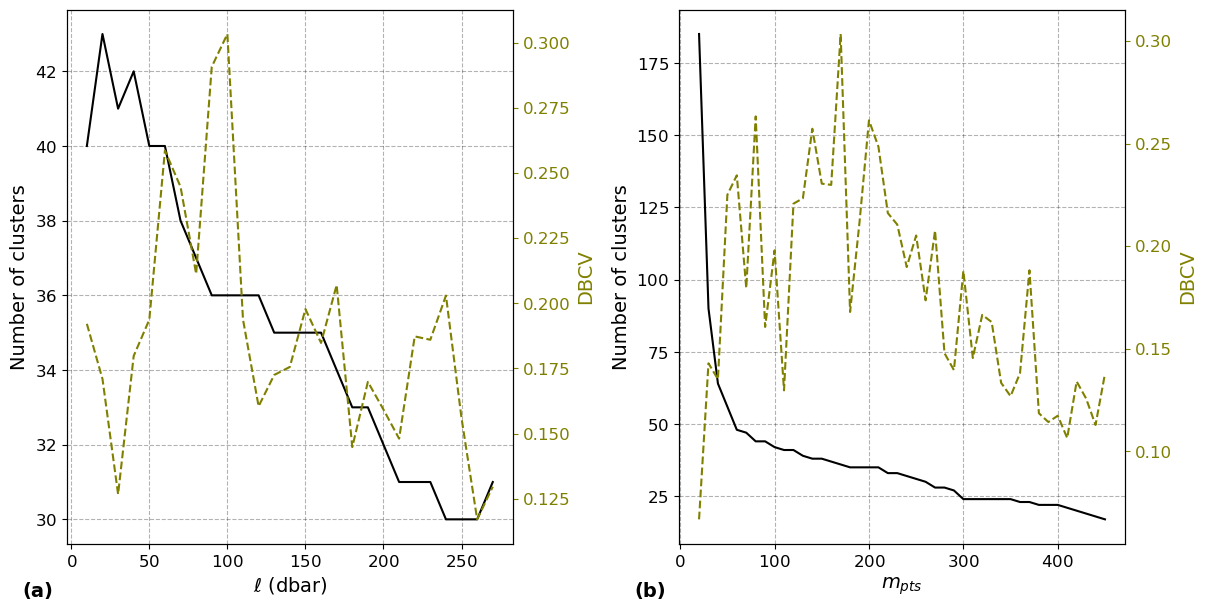

In [8]:
### Figure 3
## Parameter sweep across \ell and m_pts for ITP2, Timmermans et al. 2008
# Make the Analysis Groups
group_ps_l_ell = ahf.Analysis_Group(ds_ITP2_all, pfs_ITP2, pp_ITP2_ps_l_ell, plot_title='')
group_ps_m_pts = ahf.Analysis_Group(ds_ITP2_all, pfs_ITP2, pp_ITP2_ps_m_pts, plot_title='')
# Make the figure
if False:
    ahf.make_figure([group_ps_l_ell, group_ps_m_pts], use_same_y_axis=False, filename='Figure_3.pickle')
else:
    import dill as pl
    fig = pl.load(open('outputs/Figure_3.pickle', 'rb'))
    plt.show()

---
<a id='figure_4'></a>
[back to top](#top)

## Figure 4

Figure 4 from the study shows the lateral density ratio $R_L$ and the normalized inter-cluster range in practical salinity $IR_{S_P}$ for all the clusters found in ITP2.

### Cluster variable prefixes

The plots in Figure 4 make use of the "cluster average" prefix `ca_` which can be prepended to any regular variable, examples of which are:
* Vertical measure
    * `press`, pressure in dbar
    * `depth`, depth in meters below the surface
* Temperature
    * `iT`, insitu temperature $T$ in $^\circ$C
    * `PT`, potential temperature $\theta$ in $^\circ$C
    * `CT`, conservative temperature $\Theta$ in $^\circ$C
* Salinity
    * `SP`, practical salinity $S_P$ in g/kg
    * `SA`, absolute salinity $S_A$ in g/kg

The cluster average prefix `ca_` is one of the following prefixes which can be added to a variable:
* `pca_`, Profile cluster average
    * For each profile, the average value of the points within each cluster
    * Reduces number of points to just one per cluster per profile
* `pcs_`, Profile cluster span
    * For each profile, finds the span (maximum - minimum) of the points within each cluster
    * Reduces number of points to just one per cluster per profile
* `cmc_`, Cluster mean centered
    * For each cluster, finds the mean value, then subtracts that value from each point in that cluster
    * Should not change the number of points to display
* `ca_`, Cluster average
    * For each cluster, finds the mean value
    * Reduces number of points to just one per cluster
* `cs_`, Cluster span
    * For each cluster, finds the span (maximum - minimum) of the points
    * Reduces number of points to just one per cluster
* `cmm_`, Cluster minimum / maximum
    * For each cluster, finds the minimum and maximum value
    * Note: for a given variable `var`, this won't actually fill values in `cmm_var`, but instead fill values in both `cmin_var` and `cmax_var`
    * Reduces number of points to just two per cluster
* `nir_`, normalized inter-cluster range $IR_v$
    * For each cluster, finds the normalized inter-cluster range
    * Reduces number of points to just one per cluster
* `cRL`, cluster's lateral density ratio $R_L$
    * For each cluster, uses orthogonal distance regression to calculate $R_L$
    * Note: not actually a prefix. Do not try to apply this to a variable
    * Reduces number of points to just one per cluster

For Figure 4, we use the `ca_` prefix on the pressure, `ca_press`, to plot one point per cluster, either against the cluster's lateral density ratio `cRL` or the normalized inter-cluster range for practical salinity `nir_SP`. We use the `extra_args` dictionary to apply `plot_slopes` to the plot of `cRL` which will find a line of best fit to the data but, as mentioned above, this is the only case where it will apply a 2nd degree polynomial instead of a linear function.

- Applying profile filters
- Applying profile filters
	- Set share_y_axis to True
- Subplot a
	- Re-run HDBSCAN: False
	- Using clustering results from file
		Clustering x-axis: ['SP']
		Clustering y-axis: ['la_CT']
		Clustering m_pts:  [170]
		Clustering filters:   ['SP_range: [34.05, 34.75]']
		Clustering DBCV:   [0.30342676754223524]
		Calculating extra clustering variables
	- Marking outliers
found outliers:
[-12.73531397 -13.89352954  16.96352552]
[231.62178251 201.96688308 188.42902762]
	- Sum of square residuals: 53.552513907682375
	- Total sum of squares: 160.3532701170966
	- R^2: 0.6660341640143908
	- Inverting y-axis
	- Adding grid lines: True
- Subplot b
	- Re-run HDBSCAN: False
	- Using clustering results from file
		Clustering x-axis: ['SP']
		Clustering y-axis: ['la_CT']
		Clustering m_pts:  [170]
		Clustering filters:   ['SP_range: [34.05, 34.75]']
		Clustering DBCV:   [0.30342676754223524]
		Calculating extra clustering variables
cluster,std_SP
	- Marking outliers
found

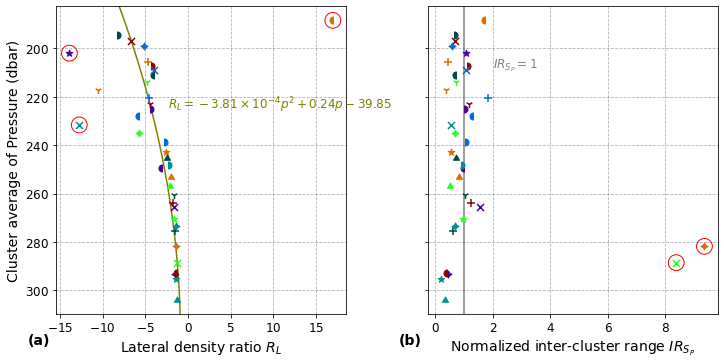

In [10]:
### Figure 4
## Evaluating clusterings with the lateral density ratio and the normalized inter-cluster range
# Make the Profile Parameters
pp_salt_R_L = ahf.Plot_Parameters(x_vars=['cRL'], y_vars=['ca_press'], clr_map='cluster', extra_args={'plot_slopes':True}, legend=False)
pp_salt_nir = ahf.Plot_Parameters(x_vars=['nir_SP'], y_vars=['ca_press'], clr_map='cluster', legend=False)
# Make the Analysis Groups
group_salt_R_L = ahf.Analysis_Group(ds_ITP2_all, pfs_ITP2, pp_salt_R_L, plot_title='')
group_salt_nir = ahf.Analysis_Group(ds_ITP2_all, pfs_ITP2, pp_salt_nir, plot_title='')
# Make the Figure
ahf.make_figure([group_salt_R_L, group_salt_nir])

### Finding outliers

Figure 4 shows several of the points circled in red. These are outliers in the horizontal variable, defined to be when the point's z-score is greater than 2. For this version of the code, the outliers will be found automatically in the following circumstances:
* If plotting with `clr_map` as `cluster`
    * Will be applied if the x variable contains `nir`, `cRL`, or `ca`
* If plotting with `clr_map` as `clr_all_same`
    * Will be applied if `plot_slopes` is `True`

I acknowledge that there may be many more scenarios where finding outliers might be helpful, but I haven't added any more functionality for this into the code.

---
<a id='figure_5'></a>
[back to top](#top)

## Figure 5

Figure 5 from the study shows two sets of example profiles from ITP2, chosen to illustrate the some of the outliers shown in Figure 4.

### Plot types

The `Plot_Parameter` objects accept an optional argument called `plot_type`. Figure 1 used this argument as `map` to add the coastlines and bathymetry. If you don't specify, `plot_type` defaults to `xy`, which is what was used for Figures 2-4. Here, we will specify the `profiles` plot type, which tells the code to plot individual profiles. However, it is important to specify which profiles to plot because the plot will be unreadable if you include the hundreds of profiles collected by an ITP.

When plotting multiple profiles, the code will automatically shift them in the x-axis so they don't overlap. Since shifting them means that the absolute value of the x-axis is meaningless, the ticks are removed and a scale bar is added.

### Profiles to plot

You can specify a set of profiles to include in your plot by adding the `pfs_to_plot` argument to the `extra_args` dictionary. The value should be a list of profile numbers. Note that, by default, the code only includes upgoing profiles. So, if the profiles you specify in this list are downgoing, they will be skipped.

Using the `pfs_to_plot` argument is very similar to using a `Data_Set` object with specific profiles specified (i.e. `ds_ITP2_pfs`). If you aren't re-running HDBSCAN, these two methods are equivalent. However, if you are re-running HDBSCAN, the algorithm will run over the data included by the `Data_Set` object and so if you would like to run the algorithm over all the data from an ITP but only display a few profiles, you will need to include all profiles in the `Data_Set` object then add the `pfs_to_plot` argument with just the profiles you wish to display.

In [8]:
### Figure 5
## Tracking clusters across a subset of profiles
# For showing multiple layers grouped into one cluster
ITP2_some_pfs_0 = [87, 89, 95, 97, 99, 101, 103, 105, 109, 111]
ITP2_some_pfs_ax_lims_0 = {'y_lims':[245,220]}
# For showing one layer split into multiple clusters
ITP2_some_pfs_1 = [67, 69, 73, 75, 81, 83, 91, 93, 97, 99]
ITP2_some_pfs_ax_lims_1 = {'y_lims':[295,270]}
# Make the Profile Parameters
pp_ITP2_some_pfs_0  = ahf.Plot_Parameters(x_vars=['SP'], y_vars=['press'], plot_type='profiles', clr_map='cluster', extra_args={'pfs_to_plot':ITP2_some_pfs_0, 'plt_noise':True}, legend=False, ax_lims=ITP2_some_pfs_ax_lims_0)
pp_ITP2_some_pfs_1  = ahf.Plot_Parameters(x_vars=['SP'], y_vars=['press'], plot_type='profiles', clr_map='cluster', extra_args={'pfs_to_plot':ITP2_some_pfs_1, 'plt_noise':True}, legend=False, ax_lims=ITP2_some_pfs_ax_lims_1)
# Make the Analysis Groups
group_ITP2_some_pfs_0 = ahf.Analysis_Group(ds_ITP2_all, pfs_ITP2, pp_ITP2_some_pfs_0, plot_title='')
group_ITP2_some_pfs_1 = ahf.Analysis_Group(ds_ITP2_all, pfs_ITP2, pp_ITP2_some_pfs_1, plot_title='')

- Applying profile filters
- Applying profile filters


### Sharing x and y axes

The code will automatically detect when you have multiple plots that have the same variable on the same axis and set them to share axis bounds. For example, in Figure 2, panels (a) and (c) have the same x-axis and the code automatcially set it so they share the same bounds. However, when making Figure 5, we don't want them to share the same bounds as we are looking at different depth ranges, so we set both `use_same_x_axis` and `use_same_y_axis` to `False` when making the figure.

### Subpanel arrangements

When making a plot with multiple subpanels, the code will automatically arrange them and size the image to be generally applicable to most plots. However, if you want to have a specific arrangement, you can add the `row_col_list` argument when making the figure. It is a list of the following in order:
* Number of rows
* Number of columns
* Aspect ratio
* Figure size

Because we want Figure 5 to have two plots, one on top of the other, we specify 2 rows and 1 column.

- Subplot a
	- Re-run HDBSCAN: False
	- Using clustering results from file
		Clustering x-axis: ['SP']
		Clustering y-axis: ['la_CT']
		Clustering m_pts:  [170]
		Clustering filters:   ['SP_range: [34.05, 34.75]']
		Clustering DBCV:   [0.30342676754223524]
	- Profiles to plot: [ 87.  89.  95.  97.  99. 101. 103. 105. 109. 111.]
	- Inverting y-axis-
	- Set y_lims to [245, 220]
	- Adding grid lines: True
- Subplot b
	- Re-run HDBSCAN: False
	- Using clustering results from file
		Clustering x-axis: ['SP']
		Clustering y-axis: ['la_CT']
		Clustering m_pts:  [170]
		Clustering filters:   ['SP_range: [34.05, 34.75]']
		Clustering DBCV:   [0.30342676754223524]
	- Profiles to plot: [67. 69. 73. 75. 81. 83. 91. 93. 97. 99.]
	- Inverting y-axis-
	- Set y_lims to [295, 270]
	- Adding grid lines: True
- Displaying figure


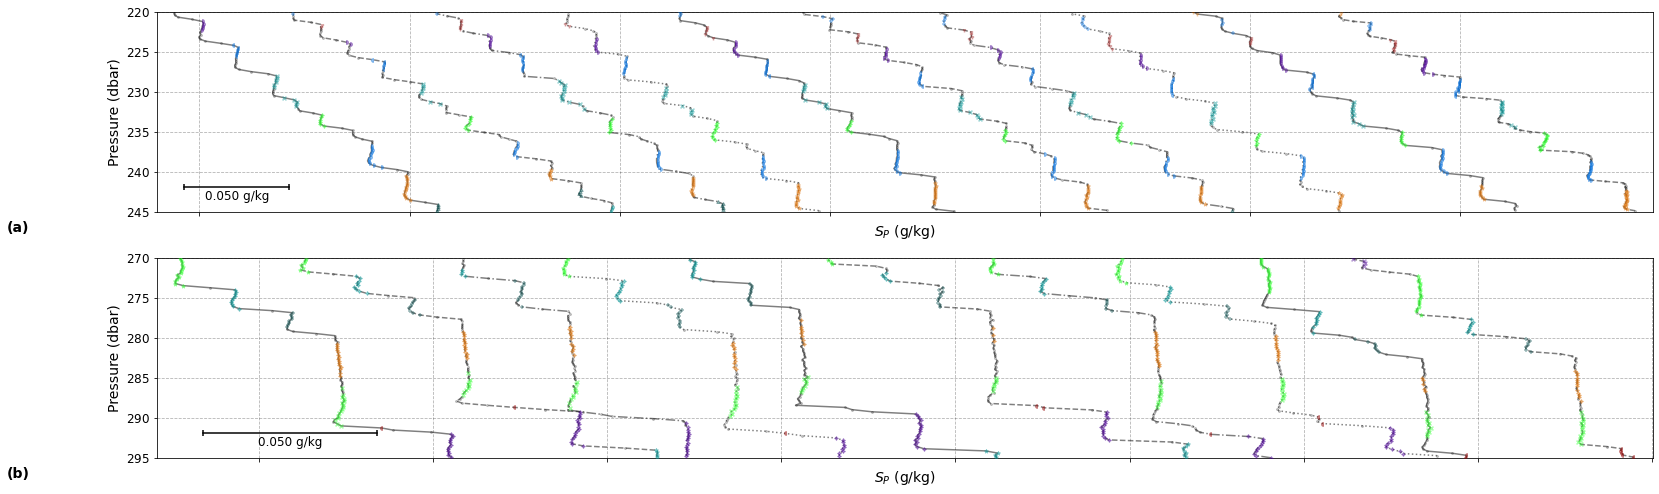

In [9]:
# Make the Figure
ahf.make_figure([group_ITP2_some_pfs_0, group_ITP2_some_pfs_1], use_same_x_axis=False, use_same_y_axis=False, row_col_list=[2,1, 0.3, 1.70])

---
<a id='figure_6'></a>
[back to top](#top)

## Figure 6

Figure 6 from the study shows, for ITP3, the average pressure, $\Theta$, and $S_P$ for each cluster within each profile across time.

This plot uses starting datetime `dt_start` on the x-axis and the profile cluster average `pca_` of pressure, conservative temperature, and practical salinity.

Note: this plot takes significantly longer to create compared to Figures 2-5 due to the fact that ITP3 has many more profiles and finding the profile cluster average is computationally demanding.

- Applying profile filters
- Applying profile filters
- Applying profile filters
	- Set share_x_axis to True
	- Turning off excess x axes
- Subplot a
	- Re-run HDBSCAN: False
	- Using clustering results from file
		Clustering x-axis: ['SP']
		Clustering y-axis: ['la_CT']
		Clustering m_pts:  [580]
		Clustering filters:   ['SP_range: [34.21, 34.82]']
		Clustering DBCV:   [0.3861603831174808]
		Calculating extra clustering variables
	- Inverting y-axis-
	- Adding grid lines: True
- Subplot b
	- Re-run HDBSCAN: False
	- Using clustering results from file
		Clustering x-axis: ['SP']
		Clustering y-axis: ['la_CT']
		Clustering m_pts:  [580]
		Clustering filters:   ['SP_range: [34.21, 34.82]']
		Clustering DBCV:   [0.3861603831174808]
		Calculating extra clustering variables
	- Inverting y-axis-
	- Adding grid lines: True
- Subplot c
	- Re-run HDBSCAN: False
	- Using clustering results from file
		Clustering x-axis: ['SP']
		Clustering y-axis: ['la_CT']
		Clustering m_pts:  [580]
		Clusterin

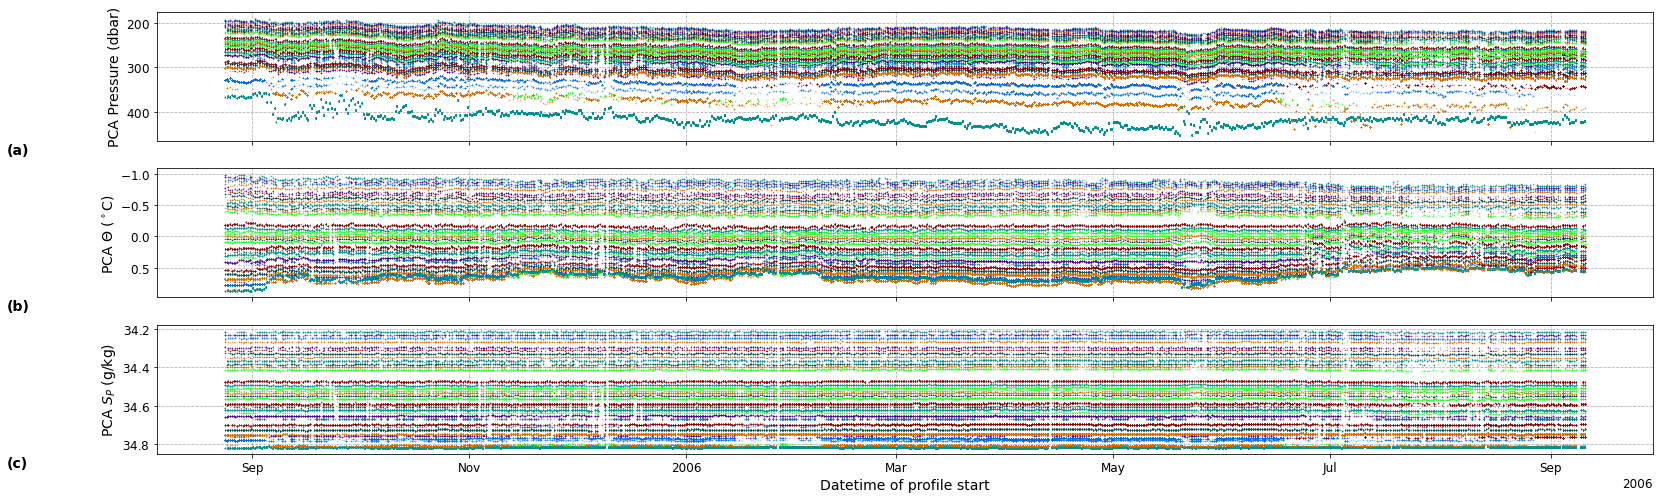

In [10]:
### Figure 6
## Tracking clusters across profiles, reproducing Lu et al. 2022 Figure 3
# Make the Profile Parameters
pp_Lu2022_fig3a = ahf.Plot_Parameters(x_vars=['dt_start'], y_vars=['pca_press'], clr_map='cluster', legend=False)
pp_Lu2022_fig3b = ahf.Plot_Parameters(x_vars=['dt_start'], y_vars=['pca_CT'], clr_map='cluster', legend=False)
pp_Lu2022_fig3c = ahf.Plot_Parameters(x_vars=['dt_start'], y_vars=['pca_SP'], clr_map='cluster', legend=False)
# Make the subplot groups
group_Lu2022_fig3a = ahf.Analysis_Group(ds_ITP3_all, pfs_ITP3, pp_Lu2022_fig3a, plot_title='')
group_Lu2022_fig3b = ahf.Analysis_Group(ds_ITP3_all, pfs_ITP3, pp_Lu2022_fig3b, plot_title='')
group_Lu2022_fig3c = ahf.Analysis_Group(ds_ITP3_all, pfs_ITP3, pp_Lu2022_fig3c, plot_title='')
# Make the figure
if False:
    # Takes a long time to run
    ahf.make_figure([group_Lu2022_fig3a, group_Lu2022_fig3b, group_Lu2022_fig3c])
else:
    import dill as pl
    fig = pl.load(open('outputs/Figure_6.pickle', 'rb'))
    plt.show()

---
<a id='figure_7'></a>
[back to top](#top)

## Figure 7

Figure 7 from the study shows the average $\Theta$ and $S_P$ for each cluster found in ITP3 data and the layers found by Lu et al. 2022.

This plot requires using data from an outside source, `Lu2022_Table_A1.csv`, which is a spreadsheet of exactly the values reported by Lu et al. 2022 in their table A1. Because of this, there is a separate script `compare_to_Lu2022.py` which creates Figure 7. We can run this file by importing it like a library:

- Loading outputs/Lu2022_Table_A1.csv
- Loading outputs/ITP3_cluster_table.csv
- Displaying figure


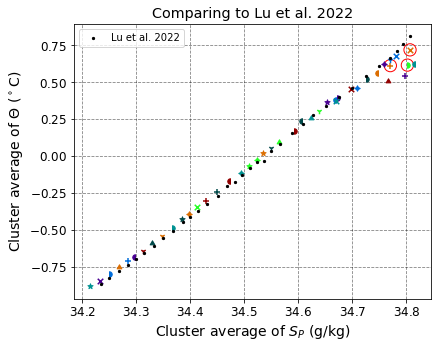

In [11]:
import compare_to_Lu2022

---
<a id='figure_8'></a>
[back to top](#top)

## Figure 8

Figure 8 from the study shows an example set of profiles from ITP3, chosen to illustrate remnant intrusions. Here, in contrast to Figure 5, we use a `Data_Set` object to select the profiles to plot. This reduces the amount of data significantly which helps the code run faster as ITP3 has many profiles compared to ITP2. This also shows how you can have multiple x-axes for profile plots. A second scale bar is added automatically.


- Applying profile filters
	- Re-run HDBSCAN: False
	- Using clustering results from file
		Clustering x-axis: ['SP']
		Clustering y-axis: ['la_CT']
		Clustering m_pts:  [580]
		Clustering filters:   ['SP_range: [34.21, 34.82]']
		Clustering DBCV:   [0.3861603831174808]
	- Profiles to plot: [313. 315. 317. 319. 321.]
	- Inverting y-axis
	- Set y_lims to [370, 300]
	- Adding grid lines: True
- Displaying figure


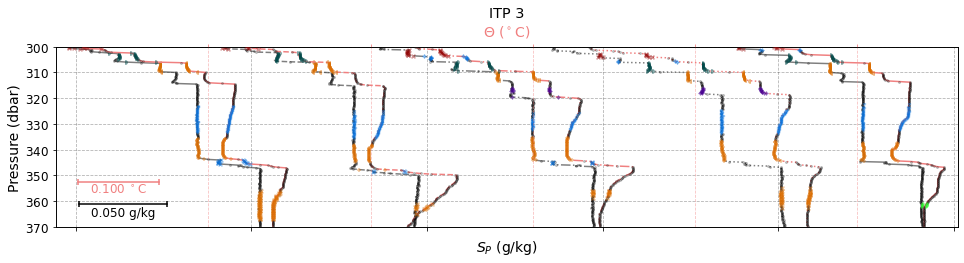

In [13]:
### Figure 8
## Tracking clusters across a subset of profiles
ITP3_some_pfs_2 = [313, 315, 317, 319, 321]
ITP3_pfs2  = {'ITP_3':ITP3_some_pfs_2}
ds_ITP3_some_pfs2 = ahf.Data_Set(ITP3_pfs2, dfs0)
ITP3_some_pfs_ax_lims_2 = {'y_lims':[370,300]}
# Make the Profile Parameters
pp_ITP3_some_pfs_2 = ahf.Plot_Parameters(x_vars=['SP','CT'], y_vars=['press'], plot_type='profiles', clr_map='cluster', extra_args={'plt_noise':True}, legend=False, ax_lims=ITP3_some_pfs_ax_lims_2)
# Make the Analysis Group
group_ITP3_some_pfs_2 = ahf.Analysis_Group(ds_ITP3_some_pfs2, pfs_ITP3, pp_ITP3_some_pfs_2)
# Make the figure
ahf.make_figure([group_ITP3_some_pfs_2], row_col_list=[1,1, 0.27, 0.90])

---
<a id='other_figures'></a>
[back to top](#top)

# Other Figures

Above, we have shown how to creat all the figures used in the study. However, there are other types of figures which this code can create which may be helpful in exploring a dataset.

---
<a id='histo_grams'></a>
[back to top](#top)

## Histograms

You can create histograms by specifying the `hist` variable for either the x or y axis. Note, you cannot have multiple variables on the axis using `hist`. By default, the number of bins is 25 per standard deviation. You can change this value by specifying `n_h_bins` in the `extra_args` dictionary.

- Applying profile filters
	- Adding grid lines: True
- Displaying figure


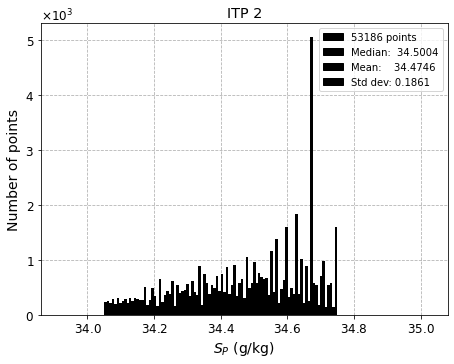

In [7]:
## Histogram of practical salinity
# Make the Plot Parameters
pp_SP_hist = ahf.Plot_Parameters(x_vars=['SP'], y_vars=['hist'], clr_map='clr_all_same')
# Make the Analysis Group
group_SP_hist = ahf.Analysis_Group(ds_ITP2_all, pfs_ITP2, pp_SP_hist)
# Make the figure
ahf.make_figure([group_SP_hist])

### Histograms by cluster

You can specify the `clr_map` to be `cluster` for that same histogram. This creates a histogram for each cluster that are all overlapping and colored accordingly. The cluster's associated symbol is plotted at the average variable value and what should be the maximum number of points value, but because of binning is usually a bit higher than that. When making histograms for clusters, a twin axis for the number of noise points is added by default. This can be turned off by setting `plt_noise` to `False` in the `extra_args`.

- Applying profile filters
	- Re-run HDBSCAN: False
	- Using clustering results from file
		Clustering x-axis: ['SP']
		Clustering y-axis: ['la_CT']
		Clustering m_pts:  [170]
		Clustering filters:   ['SP_range: [34.05, 34.75]']
		Clustering DBCV:   [0.30342676754223524]
	- Adding grid lines: True
- Displaying figure


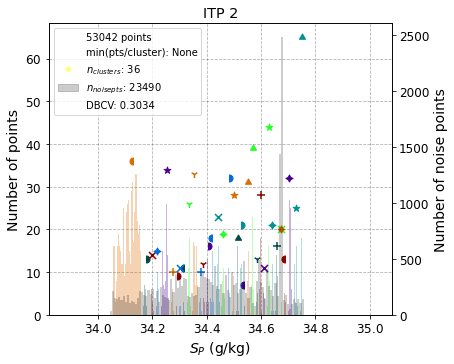

In [8]:
## Histogram of practical salinity by cluster
# Make the Plot Parameters
pp_SP_clstr_hist = ahf.Plot_Parameters(x_vars=['SP'], y_vars=['hist'], clr_map='cluster')
# Make the Analysis Group
group_SP_clstr_hist = ahf.Analysis_Group(ds_ITP2_all, pfs_ITP2, pp_SP_clstr_hist)
# Make the figure
ahf.make_figure([group_SP_clstr_hist])

### 2D Histograms

You can also make 2D histograms which show the density of points in each grid cell of a plot. You can specify parameters of how it will display:
* `clr_min`, the minimum point for the color bar. Must be 0 or greater
* `clr_max`, the maximum point for the color bar
* `clr_ext`, how to deal with values that go beyond the colorbar
    * `max` will set all values above `clr_max` to the same color and create an arrow on that end of the colorbar
* `xy_bins`, the number of bins to have in the x and y directions
    * The code doesn't currently have any way to have different numbers of bins in x and y

- Applying profile filters
	- Adding grid lines: True
- Displaying figure


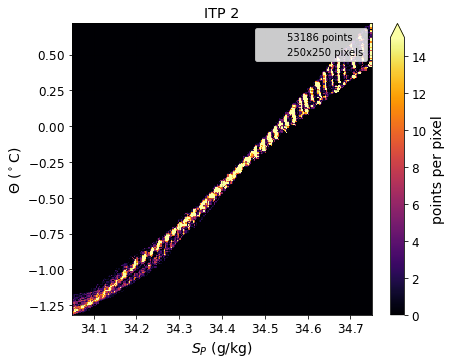

In [10]:
## Density histogram of conservative temperature vs practical salinity
# Make the Plot Parameters
pp_CT_SP_2d_hist = ahf.Plot_Parameters(x_vars=['SP'], y_vars=['CT'], clr_map='density_hist', legend=True, extra_args={'clr_min':0, 'clr_max':15, 'clr_ext':'max', 'xy_bins':250})
# Make the Analysis Group
group_CT_SP_2d_hist = ahf.Analysis_Group(ds_ITP2_all, pfs_ITP2, pp_CT_SP_2d_hist)
# Make the figure
ahf.make_figure([group_CT_SP_2d_hist])

---
<a id='HDBSCAN_params'></a>
[back to top](#top)

## Adjusting HDBSCAN parameters

There are 4 parameters which will affect what clusters the HDBSCAN algorithm finds:
* The profiles included
* The range of data used
* The value of $\ell$ selected for the moving average window
* The value of $m_{pts}$ selected

### Profiles to be included

In a `Data_Filters` object, you can filter what profiles will be included by any combination of the direction (up or down), the geographic region, or the dates they were taken.

#### Profile direction

By default, the code will only take upgoing profiles to avoid the distortions made by the wake of the instrument when it is moving downwards. The following code shows how you can add the `cast_direction` argument to a `Data_Filters` object to select one of the following three options:
* `up`
    * Just the upgoing profiles. This is selected by default if no value of `cast_direction` is given
* `down`
    * Just the downgoing profiles
* `all`
    * All the profiles regardless of direction

- Applying profile filters
- Applying profile filters
- Applying profile filters
	- Set share_x_axis to True
	- Set share_y_axis to True
- Subplot a
	- Adding grid lines: True
- Subplot b
	- Adding grid lines: True
- Subplot c
	- Adding grid lines: True
- Displaying figure


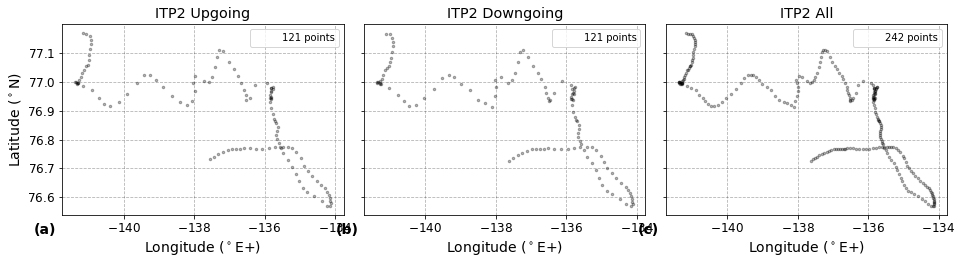

In [7]:
## Up, Down, and All profiles
# Data Filters
dfs_up  = ahf.Data_Filters(cast_direction='up')
dfs_dwn = ahf.Data_Filters(cast_direction='down')
dfs_all = ahf.Data_Filters(cast_direction='all')
# Data Sets
ds_up__ITP2 = ahf.Data_Set(ITP2_all, dfs_up)
ds_dwn_ITP2 = ahf.Data_Set(ITP2_all, dfs_dwn)
ds_all_ITP2 = ahf.Data_Set(ITP2_all, dfs_all)
# Make the Plot Parameters
pp_lon_lat = ahf.Plot_Parameters(x_vars=['lon'], y_vars=['lat'], clr_map='clr_all_same')
# Make the Analysis Groups
group_up__ITP2 = ahf.Analysis_Group(ds_up__ITP2, pfs_0, pp_lon_lat, plot_title='ITP2 Upgoing')
group_dwn_ITP2 = ahf.Analysis_Group(ds_dwn_ITP2, pfs_0, pp_lon_lat, plot_title='ITP2 Downgoing')
group_all_ITP2 = ahf.Analysis_Group(ds_all_ITP2, pfs_0, pp_lon_lat, plot_title='ITP2 All')
# Make the figure
ahf.make_figure([group_up__ITP2, group_dwn_ITP2, group_all_ITP2], row_col_list=[1,3, 0.27, 0.90])

#### Geographic region

By default, the code will not filter profiles based on geographic extent. But, you can add the `geo_extent` to a `Data_Filters` object to select a particular region. At the moment, the only region that the code recognizes is the Canada Basin, `CB`. The following code filters to just profiles within the `CB`, but since all of ITP2's profiles are within that region, you can't actually see the difference.

- Applying profile filters
- Applying profile filters
	- Set share_x_axis to True
	- Set share_y_axis to True
- Subplot a
	- Adding grid lines: True
- Subplot b
	- Adding grid lines: True
- Displaying figure


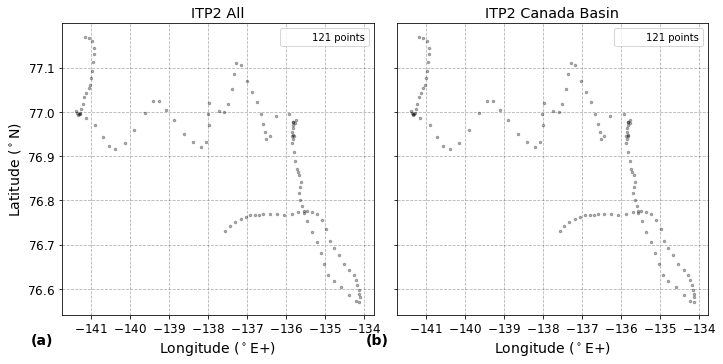

In [8]:
## Filtering to the Canada Basin
# Data Filters
dfs_0  = ahf.Data_Filters()
dfs_CB = ahf.Data_Filters(geo_extent='CB')
# Data Sets
ds_any_ITP2 = ahf.Data_Set(ITP2_all, dfs_0)
ds_CB_ITP2  = ahf.Data_Set(ITP2_all, dfs_CB)
# Make the Plot Parameters
pp_lon_lat = ahf.Plot_Parameters(x_vars=['lon'], y_vars=['lat'], clr_map='clr_all_same')
# Make the Analysis Groups
group_any_ITP2 = ahf.Analysis_Group(ds_any_ITP2, pfs_0, pp_lon_lat, plot_title='ITP2 All')
group_CB_ITP2  = ahf.Analysis_Group(ds_CB_ITP2, pfs_0, pp_lon_lat, plot_title='ITP2 Canada Basin')
# Make the figure
ahf.make_figure([group_any_ITP2, group_CB_ITP2])

#### Date Range

If you would like to look at only a certain time period, you can add the `date_range` argument to a `Data_Filters` object. It accepts a list in the format `['start_date','end_date']` where the dates are strings in the format `'YYYY/MM/DD'` or `None` to keep all profiles.

- Applying profile filters
- Applying profile filters
	- Set share_x_axis to True
	- Set share_y_axis to True
- Subplot a
	- Adding grid lines: True
- Subplot b
	- Adding grid lines: True
- Displaying figure


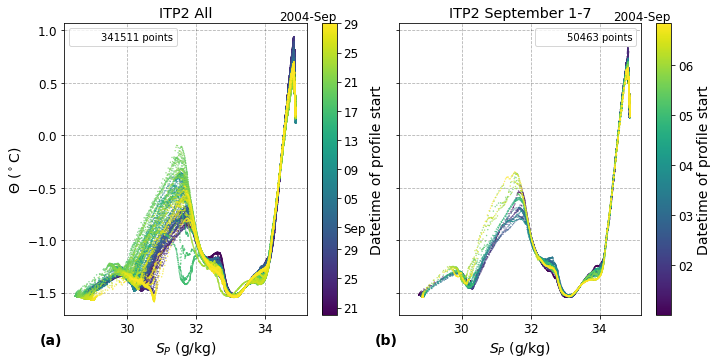

In [12]:
## Filtering to a specific date range
# Data Filters
dfs_0   = ahf.Data_Filters(date_range=None)
dfs_Sep = ahf.Data_Filters(date_range=['2004/09/01 00:00:00','2004/09/07 00:00:00'])
# Data Sets
ds_any_ITP2 = ahf.Data_Set(ITP2_all, dfs_0)
ds_Sep_ITP2 = ahf.Data_Set(ITP2_all, dfs_Sep)
# Make the Plot Parameters
pp_SP_CT = ahf.Plot_Parameters(x_vars=['SP'], y_vars=['CT'], clr_map='dt_start')
# Make the Analysis Groups
group_any_ITP2 = ahf.Analysis_Group(ds_any_ITP2, pfs_0, pp_SP_CT, plot_title='ITP2 All')
group_Sep_ITP2 = ahf.Analysis_Group(ds_Sep_ITP2, pfs_0, pp_SP_CT, plot_title='ITP2 September 1-7')
# Make the figure
ahf.make_figure([group_any_ITP2, group_Sep_ITP2])

### Data Ranges

As was shown with practical salinity `SP` above, you can add various arguments to the `Profile_Filters` object to filter to a particular range for a certain variable. They all accept lists in the format `[starting_value, ending_value]`. The variables available for filtering are:
* `p_range`
    * Pressure range
    * Note, the starting value should be the value farthest to the surface which is the larger number
* `d_range`
    * Depth range
    * Note, the starting value should be the value farthest to the surface which is the larger number
* `iT_range`
    * insitu temperature range
* `CT_range`
    * Conservative temperature range
* `PT_range`
    * Potential temperature range
* `SP_range`
    * Practical salinity range
* `SA_range`
    * Absolute salinity range

The following code shows examples of these with filters on pressure and conservative temperature.

- Applying profile filters
- Applying profile filters
	- Set share_x_axis to True
	- Set share_y_axis to True
- Subplot a
	- Adding grid lines: True
- Subplot b
	- Adding grid lines: True
- Displaying figure


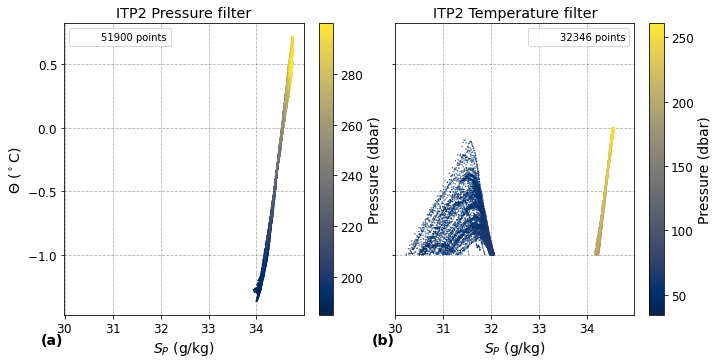

In [14]:
## Filtering to pressure and temperature ranges
# Profile Filters
pfs_press = ahf.Profile_Filters(p_range=[300,185])
pfs_temp  = ahf.Profile_Filters(CT_range=[-1,0])
# Make the Plot Parameters
pp_press = ahf.Plot_Parameters(x_vars=['SP'], y_vars=['CT'], clr_map='press')
# Make the Analysis Groups
group_p_filt_ITP2 = ahf.Analysis_Group(ds_ITP2_all, pfs_press, pp_press, plot_title='ITP2 Pressure filter')
group_t_filt_ITP2 = ahf.Analysis_Group(ds_ITP2_all, pfs_temp, pp_press, plot_title='ITP2 Temperature filter')
# Make the figure
ahf.make_figure([group_p_filt_ITP2, group_t_filt_ITP2])

### Value of $\ell$ for the moving average window

The value of $\ell$ sets the moving average window size used when calculating the local anomaly of temperature, $\Theta'$. By default, this is set by the value used in the `take_moving_average.py` script. But, you can use the `m_avg_win` argument in a `Profile_Filters` object to change this. The result is stored in variables with the moving average prefix `ma_` which is then in turn used to calculate the local anomaly `la_` variables. The code below makes a couple example plots showing the difference between the original profiles and the profiles after being smoothed with different sized moving average windows.

- Applying profile filters
	In take_m_avg(), m_avg_win: 10
- Applying profile filters
	In take_m_avg(), m_avg_win: 50
- Applying profile filters
	In take_m_avg(), m_avg_win: 100
- Applying profile filters
	In take_m_avg(), m_avg_win: 150
	- Set share_y_axis to True
- Subplot a
	- Profiles to plot: [185.]
	- Adding grid lines: True
- Subplot b
	- Profiles to plot: [185.]
	- Adding grid lines: True
- Subplot c
	- Profiles to plot: [185.]
	- Adding grid lines: True
- Subplot d
	- Profiles to plot: [185.]
	- Adding grid lines: True
- Displaying figure


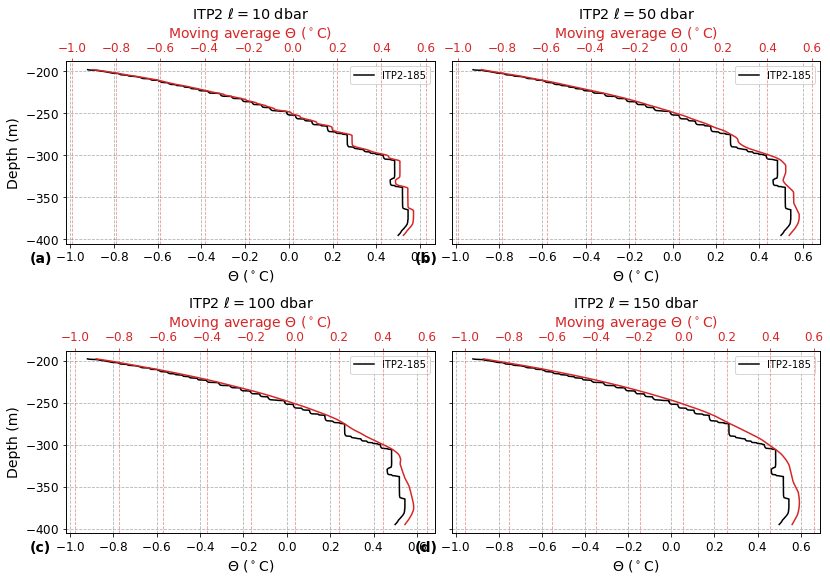

In [15]:
## Changing the value of \ell
# Data Set
ds_ITP2_185 = ahf.Data_Set({'ITP_2':[185]}, dfs0)
# Profile filters
test_p_range = [400,200]
pfs_ell_10  = ahf.Profile_Filters(p_range=test_p_range, m_avg_win=10)
pfs_ell_50  = ahf.Profile_Filters(p_range=test_p_range, m_avg_win=50)
pfs_ell_100 = ahf.Profile_Filters(p_range=test_p_range, m_avg_win=100)
pfs_ell_150 = ahf.Profile_Filters(p_range=test_p_range, m_avg_win=150)
# Make the Plot Parameters
pp_CT_ma_CT = ahf.Plot_Parameters(x_vars=['CT','ma_CT'], y_vars=['depth'], plot_type='profiles')
# Make the Analysis Groups
group_ell_010 = ahf.Analysis_Group(ds_ITP2_185, pfs_ell_10, pp_CT_ma_CT, plot_title=r'ITP2 $\ell=10$ dbar')
group_ell_050 = ahf.Analysis_Group(ds_ITP2_185, pfs_ell_50, pp_CT_ma_CT, plot_title=r'ITP2 $\ell=50$ dbar')
group_ell_100 = ahf.Analysis_Group(ds_ITP2_185, pfs_ell_100,pp_CT_ma_CT, plot_title=r'ITP2 $\ell=100$ dbar')
group_ell_150 = ahf.Analysis_Group(ds_ITP2_185, pfs_ell_150,pp_CT_ma_CT, plot_title=r'ITP2 $\ell=150$ dbar')
# Make the figure
ahf.make_figure([group_ell_010, group_ell_050, group_ell_100, group_ell_150])

### Value of $m_{pts}$ for HDBSCAN

Figure 3 showed a parameter sweep across values of $\ell$ and $m_{pts}$. Here, we show an example of re-running HDBSCAN for just one example set of parameters and viewing the resulting clusters.

- Applying profile filters
-- `cluster` not in df columns, re_run: True
	- Re-run HDBSCAN: True
	- Running HDBSCAN
		Clustering x-axis: SP
		Clustering y-axis: la_CT
		Clustering m_pts:  100
	- Adding grid lines: True


/Users/Grey/Documents/Research/PhD_Projects/Project_1-Staircase_detection/Staircase_Clustering_Detection_Algorithm/analysis_helper_functions.py:1559: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.4, h_pad=tight_layout_h_pad, w_pad=tight_layout_w_pad)


- Displaying figure


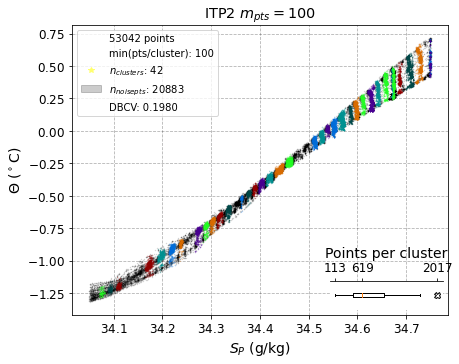

In [16]:
## Changing the value of m_pts
# Make the Plot Parameters
pp_m_pts_100 = ahf.Plot_Parameters(x_vars=['SP'], y_vars=['CT'], clr_map='cluster', legend=True, extra_args={'b_a_w_plt':True, 'cl_x_var':'SP', 'cl_y_var':'la_CT', 'm_pts':100})
# Make the Analysis Groups
group_m_pts_100 = ahf.Analysis_Group(ds_ITP2_all, pfs_ITP2, pp_m_pts_100, plot_title=r'ITP2 $m_{pts}=100$')
# Make the figure
ahf.make_figure([group_m_pts_100])

---
<a id='re_gridding'></a>
[back to top](#top)

## Re-gridding temperature and slainity data

You can add the `regrid_TS` argument to a `Profile_Filters` object to regrid the data, essentially reducing the resolution in temperature and salinity. The `regrid_TS` argument expects a list of 4 things:
* String of the 1st variable
    * For example, `CT` for conservative temperature $\Theta$
* A numerical value for the regrid of the 1st variable
    * All values of the 1st variable will be shifted to the closest value on a grid with this sized spacing
* String of the 2nd variable
    * For example, `SP` for practical salinity $S_P$
* A numerical value for the regrid of the 2nd variable
    * All values of the 2nd variable will be shifted to the closest value on a grid with this sized spacing

Below is an example comparing the original data from ITP2 in a narrowed $S_P$ range to the same data regridded to $0.01^\circ$ C and $0.005$ g/kg.

- Applying profile filters
- Applying profile filters
	- Set share_x_axis to True
	- Set share_y_axis to True
- Subplot a
	- Adding grid lines: True
- Subplot b
	- Adding grid lines: True
- Displaying figure


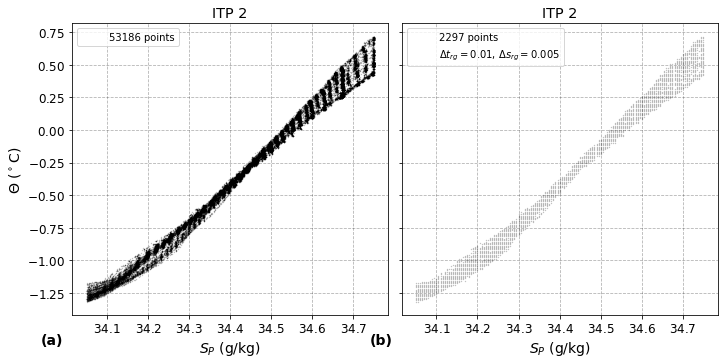

In [9]:
## Regrid
# Make the Profile Filters
pfs_0 = ahf.Profile_Filters(SP_range=ITP2_SP_range)
pfs_regrid = ahf.Profile_Filters(SP_range=ITP2_SP_range, regrid_TS=['CT',0.01,'SP',0.005])
# Make the Plot Parameters
pp_0 = ahf.Plot_Parameters(x_vars=['SP'], y_vars=['CT'], clr_map='clr_all_same', legend=True)
# Make the Analysis Group
group_0 = ahf.Analysis_Group(ds_ITP2_all, pfs_0, pp_0)
group_regrid = ahf.Analysis_Group(ds_ITP2_all, pfs_regrid, pp_0)
# Make the figure
ahf.make_figure([group_0, group_regrid])